# Comparison of Bayesian and Chi-Square Testing

## Objectives:
* Compare the Bayesian and Frequentist approach to solving a problem
* Observe that Bayesian is often able to reach a conclusion based on less data

Suppose there are two medicines under consideration to treat a disease. Medicine A is well-known to result in a 50% survival rate. Medicine B has not been studied. (Its true survival rate is 52%, but this is not known until we study it.)

We need to derive a test to determine if Medicine B is better than Medicine A and examine how much data we need to make this determination.

How would we approach this problem using the frequentist (Chi-Squared) technique and the Bayesian technique? How do these approaches work for various sample sizes?

In [13]:
import numpy as np
'''Change or remove random seed to try this with different data'''
np.random.seed(123456)
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, chisquare

'''The threshold value defines the baseline (or True) effectiveness
of the medicine being studied'''
threshold = 0.52

In [14]:
sample_size = n = 50
''' B = outcomes of `n` patients who have been given medicne B
1 = survival, 0 = perish '''
B = 1*(np.random.random(n) < threshold)
print('The apparent effectiveness of this medicine (as measured from a small sample) is: ')
print(B.mean())

The apparent effectiveness of this medicine (as measured from a small sample) is: 
0.58


## First, the frequentist approach

Use the chi-squared test. If the p value is greater than 0.05, a frequentist would say that we can't reject the null hypothesis and therefore we continue to believe it, even if there is some reason to suspect the new medicine is better.

In [15]:
survivals = B.sum()
deaths = n - survivals
chi_p_value = chisquare([deaths, survivals])[1]
chi_p_value

0.2578990352923363

## Next, the Bayesian Approach

Rather than consider whether the null hypothesis can be rejected, we consider the proportion of time that Medicine B appears to be better than *status quo*.

In [16]:
probability_B_better = (beta(1+survivals, 1+deaths).rvs(100_000)>.5).mean()
probability_B_better


0.87008

## Let's see how this changes as sample size increases

let's suppose we have a large number of trial results, but we'll start by only considering a small subset of them.  As the size of this subset increases, we gain more confidence in our conclusions

In [17]:
outcomes = 1*(np.random.random(100_000) < threshold)
print(f'A few outcomes: {outcomes[:20]}')
print(f'The average effectivenss, (as measured from a large sample set): {outcomes.mean()}')

A few outcomes: [0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1]
The average effectivenss, (as measured from a large sample set): 0.51847


In [18]:
def comparison(n):
    trials = n['trials']
    trial_outcomes = outcomes[:trials]
    survivals = trial_outcomes.sum()
    deaths = trials - survivals
    frequentist_p = chisquare([deaths, survivals])[1]
    bayesian_prob = (beta(1+survivals, 1+deaths).rvs(100_000)>.5).mean()
    return pd.Series({'survivals':survivals, 
                      'deaths':deaths, 
                      'p':frequentist_p, 
                      'bayes':bayesian_prob})

In [19]:
df = pd.DataFrame({'trials':np.unique(np.logspace(2,5, 200).astype(np.int))}, dtype = np.int)
x = pd.concat([df, df.apply(comparison, axis = 1)], axis = 1).set_index('trials')
x.head(20)

C:\Users\Smith\AppData\Local\Temp\ipykernel_13932\2550790105.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = pd.DataFrame({'trials':np.unique(np.logspace(2,5, 200).astype(np.int))}, dtype = np.int)


,survivals,deaths,p,bayes
trials,,,,
100,54.0,46.0,0.423711,0.78608
103,55.0,48.0,0.490364,0.75501
107,57.0,50.0,0.498586,0.74996
110,59.0,51.0,0.445601,0.77616
114,63.0,51.0,0.261054,0.86845
118,67.0,51.0,0.140773,0.93000
123,69.0,54.0,0.176214,0.91072
127,72.0,55.0,0.131425,0.93417
132,74.0,58.0,0.163734,0.91778


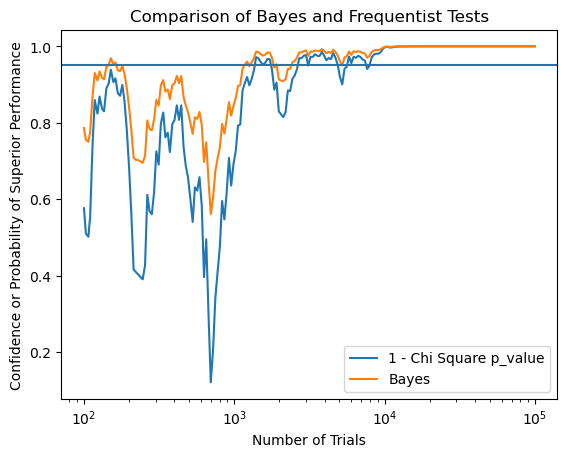

In [20]:
plt.plot(1-x['p'], label = '1 - Chi Square p_value')
plt.plot(x['bayes'], label = 'Bayes')
plt.axhline(.95)
plt.xscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Confidence or Probability of Superior Performance')
plt.title('Comparison of Bayes and Frequentist Tests')
plt.legend();

This shows us that both the Chi Square test and the Bayesian test approach a high level of certainty for large sample sizes.
Note that Bayes is nearly always above the Frequentist, and has less variation. Generally, Bayes will exceed the 95% threshold sooner.

How much sooner is Bayes arriving at that conclusion?

In [21]:
print('First time Bayes exceeded 95%: ')
print(x[x['bayes'] > .95].index.min(),' trials')

First time Bayes exceeded 95%: 
146  trials


In [22]:
print('First time Chi Squared exceeded 95% (p<.05): ')
print(x[x['p'] < .05].index.min(),' trials')

First time Chi Squared exceeded 95% (p<.05): 
1398  trials


In [23]:
print('Last time Bayes was less than 95%')
print(x[x['bayes'] < .95].index.max(), ' trials')

Last time Bayes was less than 95%
5231  trials


In [24]:
print('Last time Chi Squared was less than 95% (p>.05): ')
print(x[x['p'] > .05].index.max(), ' trials')

Last time Chi Squared was less than 95% (p>.05): 
7934  trials


# Conclusion: 

### While both Bayesian and Frequentist approaches were able to arrive at the correct result, Bayes was able to reach that result with several hundred, or several thousand fewer trials.

### In the real world, this could save time, money, effort and possibly even lives.

## Explore:

* Try changing the np.random.seed() value in the first cell (or remove this statement) to try this with different values
* Try changing the threshold value to see how this changes when the effect size changes.
* If threshold = 0.5, the new medicine, B, should be identical to the *status quo* medicine.